# What are the correct units?

What are the units used for the numerical computation? How do we choose them? How do they relate to physical units? This notebook will help you understand the units used in the numerical computation.

### We have five units, what are they?


 $v_0$: velocity

 $r_0$: distance

 $\tau$: time

 $m$: mass

 $a_0$: acceleration

Additionally, we must consider 
G: the gravitational constant





## (1) PICK $v_0$, $r_0$, and $m$ 
We will set the numerical distance to be 1 pc and the numerical velocity to be 1 km/s. 

$$ r_o = 1 \text{pc}$$

$$ v_o = 1 \text{km/s}$$

$$ m = 1 \text{M}_{\odot}$$

Afterwards, we can find the units for the time as the distance divded by the velocity.

$$ t_o = \frac{r_o}{v_o}  = 1 \frac{\text{s pc }}{\text{km}} $$

Now we can get rid of the units of distance by knowing the conversion factor between pc and km:

$$ 1 \text{ pc} = 30,856,775,812,800 \text{ km}$$

Convert seconds to years

$$ \frac{\text{min}}{60 s} \frac{\text{hr}}{60 \text{min}} \frac{\text{day}}{24 \text{hr}} \frac{\text{yr}}{365 \text{day}}  = \frac{\text{yr}}{31536000 \text{ s}}$$


#### Express the time in years

We can now express the time in years:

$$ t_o = 978461.9423135464 \text{ yr}$$





In [1]:
secsInYr = 31536000
pcToKm = 30856775812800
tunit= pcToKm / secsInYr
print("tunit",tunit, "yr")

tunit 978461.9423135464 yr


## Use astropy for unit conversion



In [2]:
import astropy.units as u
t = 1*u.pc * u.s / u.km
print("astropy's", t.to(u.yr))
print("Relative error", 2*100*(t.to(u.yr).value - tunit)/(t.to(u.yr).value + tunit), "%")

astropy's 977792.2216807891 yr
Relative error -0.06846969530685505 %


These are consistent. We will opt for using the astropy units package for convienence.

## Find the gravitational constant

We can now find the numerical value to use for the gravitational constant using astropy. This is a simple as taking the known value for the gravitational constant and converting it to the units we are using. However, instead of conceptualizaing the gravitational constant as $[\text{FORCE } \text{ DIST}^2 \text{ MASS}^{-2}]$ note that we are going to conceptualize the gravitational constant as:

$$ G = [\text{DIST } \text{ VELOCITY}^2 \text{ MASS}^{-1}]$$



In [3]:
from astropy import constants as const
outunits=u.pc * (u.km / u.s)**2 / (u.Msun)
G = const.G.to(outunits)
print(G)

0.00430091727003628 km2 pc / (s2 solMass)


This is the numerical value we are going to use for all of our calculations. 

## a note on acceleration 

With such mixed units, how do we express the acceleration? pc / yr^2 ? km / yr^2? km/s/yr? The acceleration is strange because we are going to mix units of time. Since we are going to use a numerical schema for computing velocities, i.e. $v_{i+1} \sim v_i + a_i\delta t$ the acceleration is going to be $v_0/\tau$, or in other words:

$$ a_0 = \frac{v_0}{\tau} = \frac{1 \text{ km/s}}{978461.9423135464 \text{ yr}} $$


These are quite unintuitive units but we can convert them if needed. I haven't run into a case where I've need to look at the accelerations yet, just energy and positions. 

# Time step?

What should the time step be? How can we know it is small enough? We have a series of characteristic times that can be looked at to set the initial scaling of our problem. Also, to know if the time step is small enough, we can look at the stability of the numerical scheme through energy conervation once the integration is complete. There are also numerical schema's that have adaptive time steps (see chapter 16 of Numerical Recipes in C). This will not be considered here (eventually, I would like to study this!).  


To start, I like the idea of basing the time step on the orbital period of the star. 

$$ T = \frac{r}{2\pi v_{\text{circ}}}$$


And in general, the circular velocity is when the centripial force is equal to the gravitational force.

$$ \frac{v_c^2}{r} = -\nabla\Phi$$

Now, we can consider our plummer system:

$$ \Phi = -\frac{GM_t}{\sqrt{r^2 + b^2}}$$

we can find the force through the potential:

$$ F = -\frac{d\Phi}{dr} = \frac{GM_t r}{(r^2 + b^2)^{3/2}}$$


if we plug in the circular velocity, we get:

$$ v_c^2 = \frac{GM_t r^2}{(r^2 + b^2)^{3/2}}$$


Finally, if we evaluate this at the center of the plummer sphere, we get:

$$ v_c^2 = \frac{GM_t b^2}{(2b^2)^{3/2}} = \frac{GM_t}{b 2^{3/2}}$$

Now, we can find the orbital period:

$$ T = \frac{2^{7/4}\pi b^{3/2}}{\sqrt{GM_t}}$$

Next, we can choose the time step to be a small fraction, such as 1/10000, of the orbital period.

$$ \delta t = \frac{1}{10000} T$$


Also, interestingly, we can see the depdencies on the scale length and the total mass of the plummer sphere.

$$ T = \frac{2^{7/4}\pi }{\sqrt{G}} \frac{b^{3/2}}{\sqrt{M_t}}$$


we can visualize this:


In [54]:
import numpy as np
n=100
bs=np.linspace(1,100,n) * u.pc
ms=np.logspace(1,7,n) * u.Msun
Bs,Ms=np.meshgrid(bs,ms)
cnst = 2**(7/4) * np.pi / np.sqrt(G)
T = cnst * Bs**(3/2) / np.sqrt(Ms)

Text(0.5, 1.0, 'Plummer circular orbital period at $b$')

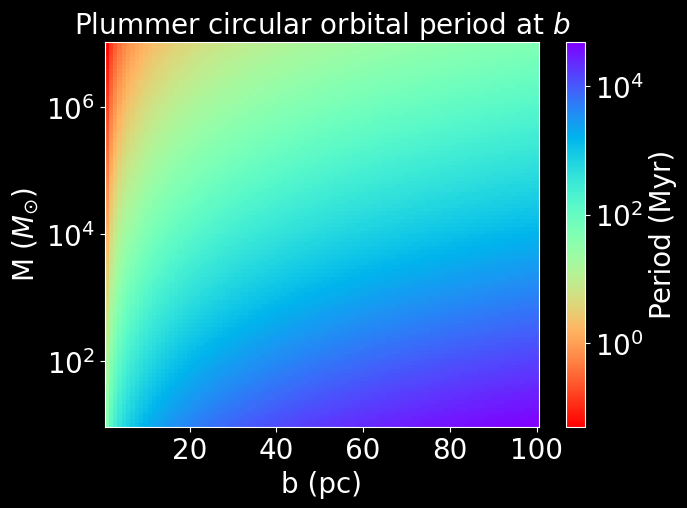

In [55]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# set dark background
plt.style.use("dark_background")
mpl.rcParams["font.size"]=20

fig,ax=plt.subplots(1,1,figsize=(7,5))
im=ax.pcolor(Bs.value,Ms.value,T.to(u.Myr).value,cmap="rainbow_r",norm=mpl.colors.LogNorm())
cbar=fig.colorbar(im)
ax.set_xlabel("b (pc)",fontsize=20)
ax.set_ylabel(r"M $(M_{\odot})$", fontsize=20)
ax.set_yscale("log")
cbar.set_label(r"Period (Myr)", fontsize=20)
ax.set_title("Plummer circular orbital period at $b$", fontsize=20)
